# TTI elastic with a sinusoid boundary

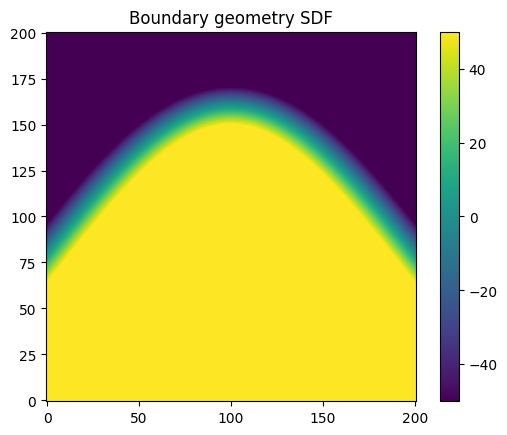

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid_new_hi_res', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

zero = sp.core.numbers.Zero()
cutoff = {(zero, zero): 0.}

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4

ux = dv.TimeFunction(name='ux', grid=grid, space_order=s_o, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=s_o, time_order=2)

# Material parameters
v_p0 = 1.
v_s0 = 0.4  # 0.65
de = 0.1
ep = 0.25
rho = 1.
b = 1/rho
th = np.radians(45)

# Seismic wavespeeds
v_p02 = v_p0**2
v_s02 = v_s0**2
v_pn2 = (1+2*de)*v_p0**2
v_px2 = (1+2*ep)*v_p0**2

# VTI stiffness tensor entries (uses conventions from 3D case)
c11 = rho*v_px2
c13 = rho*np.sqrt((v_p02-v_s02)*(v_pn2-v_s02))-rho*v_s02
c33 = rho*v_p02
c44 = rho*v_s02

# Assemble the VTI stiffness tensor (Voigt notation)
C = sp.Matrix([[c11, c13, 0],
               [c13, c33, 0],
               [0, 0, c44]])

In [4]:
# Stiffness tensor rotation

# Rotation matrix
R = sp.Matrix([[np.cos(th), -np.sin(th)],
               [np.sin(th), np.cos(th)]])

# Apparatus to perform rotation
voigt = {(0, 0): 0, (1, 1): 1, (0, 1): 2, (1, 0): 2}


def as_tensor(matrix):
    """Convert Voigt notation to stiffness tensor in 2D"""
    tensor = sp.tensor.array.MutableDenseNDimArray.zeros(2, 2, 2, 2)
    
    for k1, v1 in voigt.items():
        i, j = k1
        alpha = v1
        for k2, v2 in voigt.items():
            k, l = k2
            beta = v2
            tensor[i, j, k, l] = matrix[alpha, beta]
    return tensor


def tensor_to_matrix(tensor):
    """Convert stiffness tensor to Voigt notation in 2D"""
    matrix = sp.zeros(3, 3)
    
    for k1, v1 in voigt.items():
        i, j = k1
        alpha = v1
        for k2, v2 in voigt.items():
            k, l = k2
            beta = v2
            matrix[alpha, beta] = tensor[i, j, k, l]
    return matrix


def rotate(matrix, R):
    """Rotate a stiffness tensor in Voigt notation using matrix R"""
    C = as_tensor(matrix)
    rotated = sp.tensor.array.MutableDenseNDimArray.zeros(2, 2, 2, 2)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for ii in range(2):
                        for jj in range(2):
                            for kk in range(2):
                                for ll in range(2):
                                    gg = R[ii, i]*R[jj, j]*R[kk, k]*R[ll, l]
                                    rotated[i, j, k, l] += gg*C[ii, jj, kk, ll]
                    rotated[i, j, k, l] = sp.collect(rotated[i, j, k, l],
                                                     [c11, c13, c44, c33])
    return tensor_to_matrix(rotated)


# Get the rotated stiffness tensor (D)
D = rotate(C, R)

# Shorthands for components of D
d11 = D[0, 0]
d12 = D[0, 1]
d13 = D[0, 2]
d22 = D[1, 1]
d23 = D[1, 2]
d33 = D[2, 2]

In [5]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

# Note that a factor of rho has been removed here
txx = d11*ux.dx + d12*uy.dy + d13*ux.dy + d13*uy.dx
tyy = d12*ux.dx + d22*uy.dy + d23*ux.dy + d23*uy.dx
txy = d13*ux.dx + d23*uy.dy + d33*ux.dy + d33*uy.dx

# With fourth-order boundary conditions
bc_list = [dv.Eq(nx*txx + ny*txy, 0),
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(ux.dx2dy*(3*d11*d13*nx + d11*d33*ny + d12**2*ny
                           + d12*d13*nx + d12*d33*ny + 2*d13**2*ny
                           + d13*d23*ny + 2*d13*d33*nx)
                 + ux.dx3*(d11**2*nx + d11*d13*ny + d12*d13*ny + d13**2*nx)
                 + ux.dxdy2*(d11*d33*nx + 2*d12*d23*ny + d12*d33*nx
                             + 2*d13**2*nx + d13*d23*nx + 3*d13*d33*ny
                             + d23*d33*ny + d33**2*nx)
                 + ux.dy3*(d13*d33*nx + d23**2*ny + d23*d33*nx + d33**2*ny)
                 + uy.dx2dy*(d11*d12*nx + d11*d23*ny + d12*d23*ny
                             + d12*d33*nx + 2*d13**2*nx + d13*d22*ny
                             + d13*d23*nx + 2*d13*d33*ny + d23*d33*ny
                             + d33**2*nx)
                 + uy.dx3*(d11*d13*nx + d11*d33*ny + d13*d23*ny + d13*d33*nx)
                 + uy.dxdy2*(2*d12*d13*nx + d12*d22*ny + d12*d23*nx
                             + 2*d13*d23*ny + d13*d33*nx + d22*d33*ny
                             + d23**2*ny + 2*d23*d33*nx + d33**2*ny)
                 + uy.dy3*(d12*d33*nx + d22*d23*ny + d23**2*nx + d23*d33*ny), 0),
           dv.Eq(ux.dx2dy*(d11*d12*nx + d11*d33*nx + d12*d13*ny + 2*d12*d23*ny
                           + d13**2*nx + 2*d13*d23*nx + 2*d13*d33*ny
                           + d23*d33*ny + d33**2*nx)
                 + ux.dx3*(d11*d13*nx + d12*d33*ny + d13**2*ny + d13*d33*nx)
                 + ux.dxdy2*(d11*d23*nx + d12*d13*nx + d12*d22*ny + d12*d33*ny
                             + d13*d22*nx + d13*d23*ny + d13*d33*nx
                             + 2*d23**2*ny + 2*d23*d33*nx + d33**2*ny)
                 + ux.dy3*(d13*d23*nx + d22*d23*ny + d22*d33*nx + d23*d33*ny)
                 + uy.dx2dy*(2*d12*d13*nx + d12*d33*ny + d13*d23*ny
                            + d13*d33*nx + d22*d33*ny + 2*d23**2*ny
                            + 3*d23*d33*nx + d33**2*ny)
                 + uy.dx3*(d13**2*nx + d13*d33*ny + d23*d33*ny + d33**2*nx)
                 + uy.dxdy2*(d12**2*nx + d12*d23*ny + d12*d33*nx + d13*d23*nx
                             + 3*d22*d23*ny + d22*d33*nx + 2*d23**2*nx
                             + 2*d23*d33*ny)
                 + uy.dy3*(d12*d23*nx + d22**2*ny + d22*d23*nx + d23**2*ny), 0)]
# bc_list = [dv.Eq(nx*txx + ny*txy, 0),
#            dv.Eq(nx*txy + ny*tyy, 0)]

bcs = BoundaryConditions(bc_list)

In [6]:
from schism import Boundary

boundary = Boundary(bcs, bg)

derivs = (ux.dx2, ux.dy2, ux.dxdy, uy.dx2, uy.dy2, uy.dxdy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(ux(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [7]:
from examples.seismic import TimeAxis, RickerSource

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

t0 = 0.  # Simulation starts a t=0
tn = 800.  # 650.  # Simulation last 0.65 seconds (650 ms)
dt = 0.5*grid.spacing[0]/v_p0  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.006  # 0.008  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 650.

In [8]:
rhs_ux = b*(d11*ux.dx2 + 2*d13*ux.dxdy + d33*ux.dy2
            + d13*uy.dx2 + (d12+d33)*uy.dxdy + d23*uy.dy2)
rhs_uy = b*(d13*ux.dx2 + (d12+d33)*ux.dxdy + d23*ux.dy2
            + d33*uy.dx2 + 2*d23*uy.dxdy + d22*uy.dy2)

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux.subs(subs))

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy.subs(subs))

In [9]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)

In [10]:
nsnaps = 4

# Set up snapshotting
steps = src.nt
factor = int(steps/nsnaps)
t_sub = dv.ConditionalDimension('t_sub', parent=grid.time_dim,
                                factor=factor)

# Buffer size needs to be more robust
uxsave = dv.TimeFunction(name='uxsave', grid=grid, time_order=0,
                         save=nsnaps+1, time_dim=t_sub)
uysave = dv.TimeFunction(name='uysave', grid=grid, time_order=0,
                         save=nsnaps+1, time_dim=t_sub)

eq_save_ux = dv.Eq(uxsave, ux)
eq_save_uy = dv.Eq(uysave, uy)

In [11]:
op = dv.Operator([eq_ux, eq_uy,
                  eq_save_ux, eq_save_uy] + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 7.05 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=7.045895999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0007689999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00027699999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

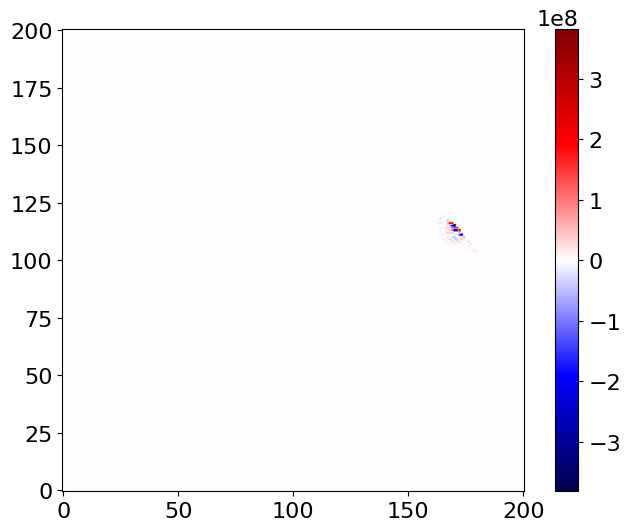

In [12]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic',
           vmax=np.amax(np.abs(ux.data[1])), vmin=-np.amax(np.abs(ux.data[1])))
plt.colorbar()
plt.show()

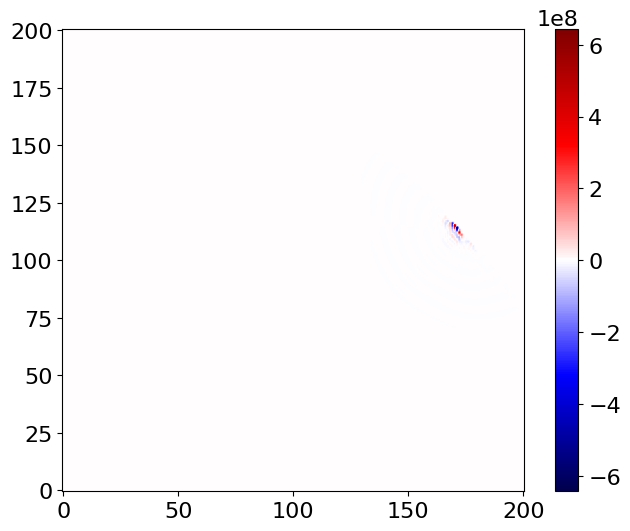

In [13]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic',
           vmax=np.amax(np.abs(uy.data[1])), vmin=-np.amax(np.abs(uy.data[1])))
plt.colorbar()
plt.show()

In [14]:
# Save the fields
ux_old = ux.data.copy()
uy_old = uy.data.copy()

uxsave_old = uxsave.data.copy()
uysave_old = uysave.data.copy()

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

uxsave.data[:] = 0
uysave.data[:] = 0

In [15]:
import sympy as sp

# Set up wavenumber filter
def get_filter(f, dim, hs, mask):
    """Return a set of equations to apply the filter"""
    if hs == 4:
        # 8th order
        coeffs = np.array([-1., 8., -28., 56., 186., 56., -28., 8., -1.])/256.
    elif hs == 3:
        # 6th order
        coeffs = np.array([1., -6., 15., 44., 15., -6., 1.])/64.
    elif hs == 2:
        # 4th order
        coeffs = np.array([-1., 4., 10., 4., -1.])/16.
    elif hs == 1:
        coeffs = np.array([1., 2., 1.])/4.
        
    h_dim = dim.spacing
    indices = tuple(range(-hs, 1+hs))
    points = [f.subs(dim, dim+i*h_dim) for i in indices]

    expr = sum(coeff*point for coeff, point in zip(coeffs, points))
    
    # Temporary function to store filtered values
    # NOTE: Could just have one of these and reuse it
    f_temp = dv.Function(name=f.name+'_temp_'+mask.name+'_'+dim.name, grid=f.grid, space_order=0)
    
    # Fill temp with filtered values, then set f to filtered values
    eq_filter = dv.Eq(f_temp, expr, implicit_dims=mask)
    eq_set = dv.Eq(f, f_temp, implicit_dims=mask)
    
    return [eq_filter, eq_set]

hs = 4
x, y = grid.dimensions

mask4 = dv.ConditionalDimension(name='mask4', parent=y,
                                condition=dv.Gt(sdf, 3*grid.spacing[0]))
mask3 = dv.ConditionalDimension(name='mask3', parent=y,
                                condition=sp.And(dv.Gt(sdf, 2*grid.spacing[0]),
                                                 dv.Le(sdf, 3*grid.spacing[0])))
mask2 = dv.ConditionalDimension(name='mask2', parent=y,
                                condition=sp.And(dv.Gt(sdf, grid.spacing[0]),
                                                 dv.Le(sdf, 2*grid.spacing[0])))
mask1 = dv.ConditionalDimension(name='mask1', parent=y,
                                condition=sp.And(dv.Gt(sdf, 0),
                                                 dv.Le(sdf, grid.spacing[0])))

# Filter velocity components
filter_ux_x4 = get_filter(ux.forward, x, 4, mask4)
filter_ux_y4 = get_filter(ux.forward, y, 4, mask4)
filter_uy_x4 = get_filter(uy.forward, x, 4, mask4)
filter_uy_y4 = get_filter(uy.forward, y, 4, mask4)

filter_ux_x3 = get_filter(ux.forward, x, 3, mask3)
filter_ux_y3 = get_filter(ux.forward, y, 3, mask3)
filter_uy_x3 = get_filter(uy.forward, x, 3, mask3)
filter_uy_y3 = get_filter(uy.forward, y, 3, mask3)

filter_ux_x2 = get_filter(ux.forward, x, 2, mask2)
filter_ux_y2 = get_filter(ux.forward, y, 2, mask2)
filter_uy_x2 = get_filter(uy.forward, x, 2, mask2)
filter_uy_y2 = get_filter(uy.forward, y, 2, mask2)

filter_ux_x1 = get_filter(ux.forward, x, 1, mask1)
filter_ux_y1 = get_filter(ux.forward, y, 1, mask1)
filter_uy_x1 = get_filter(uy.forward, x, 1, mask1)
filter_uy_y1 = get_filter(uy.forward, y, 1, mask1)

In [16]:
op = dv.Operator([eq_ux, eq_uy]
                 + filter_ux_x4 + filter_ux_y4
                 + filter_uy_x4 + filter_uy_y4
                 + filter_ux_x3 + filter_ux_y3
                 + filter_uy_x3 + filter_uy_y3
                 + filter_ux_x2 + filter_ux_y2
                 + filter_uy_x2 + filter_uy_y2
                 + filter_ux_x1 + filter_ux_y1
                 + filter_uy_x1 + filter_uy_y1
                 + [eq_save_ux, eq_save_uy]
                 + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 7.25 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=7.027267999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.069906, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.043931000000000026, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.018903999999999994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.019834, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section5', rank=None),
                     PerfEntry(time=0.017505000000000017, gflopss=0.0, gpointss=0.0, oi=0.0, o

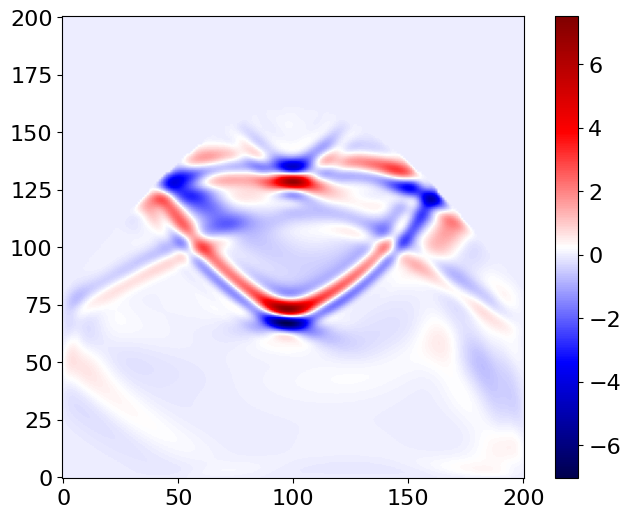

In [17]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

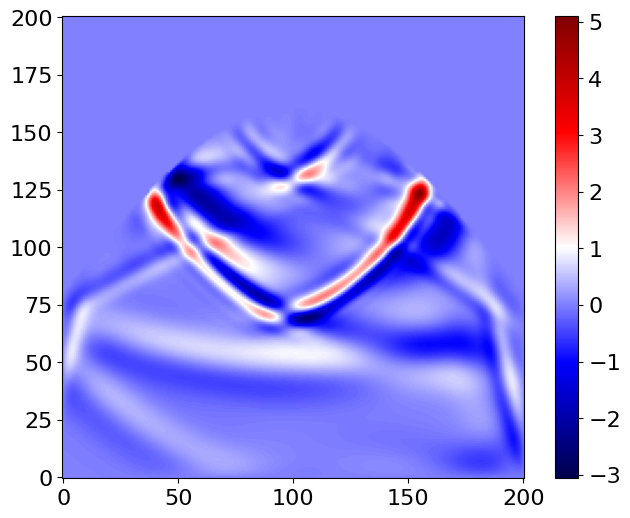

In [18]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

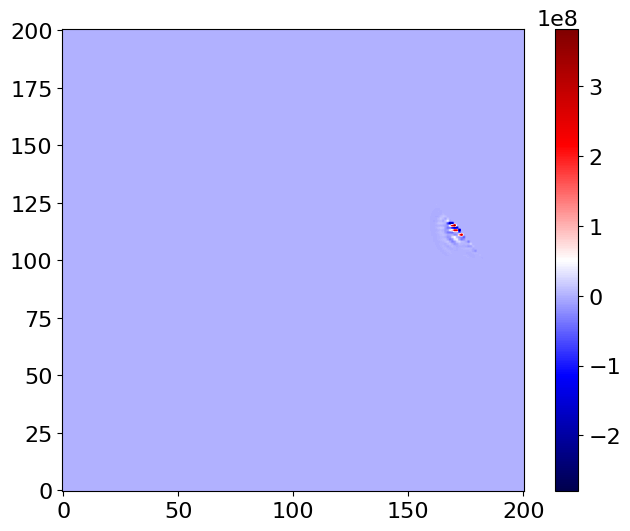

In [19]:
plt.imshow(ux.data[1].T - ux_old[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

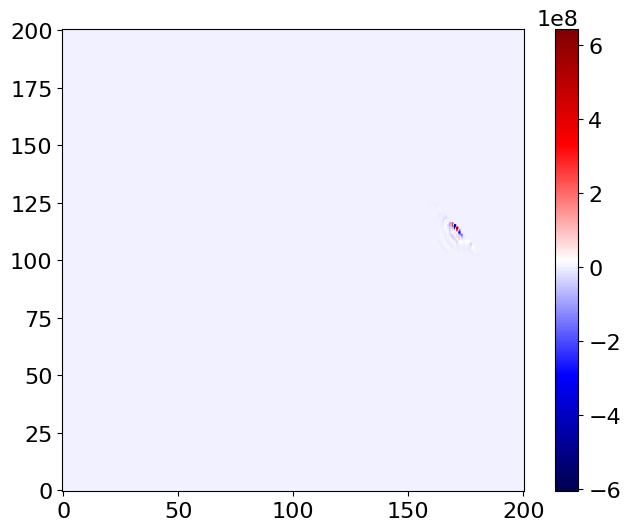

In [20]:
plt.imshow(uy.data[1].T - uy_old[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

195.03322
226.17355
243.05963
238.97766


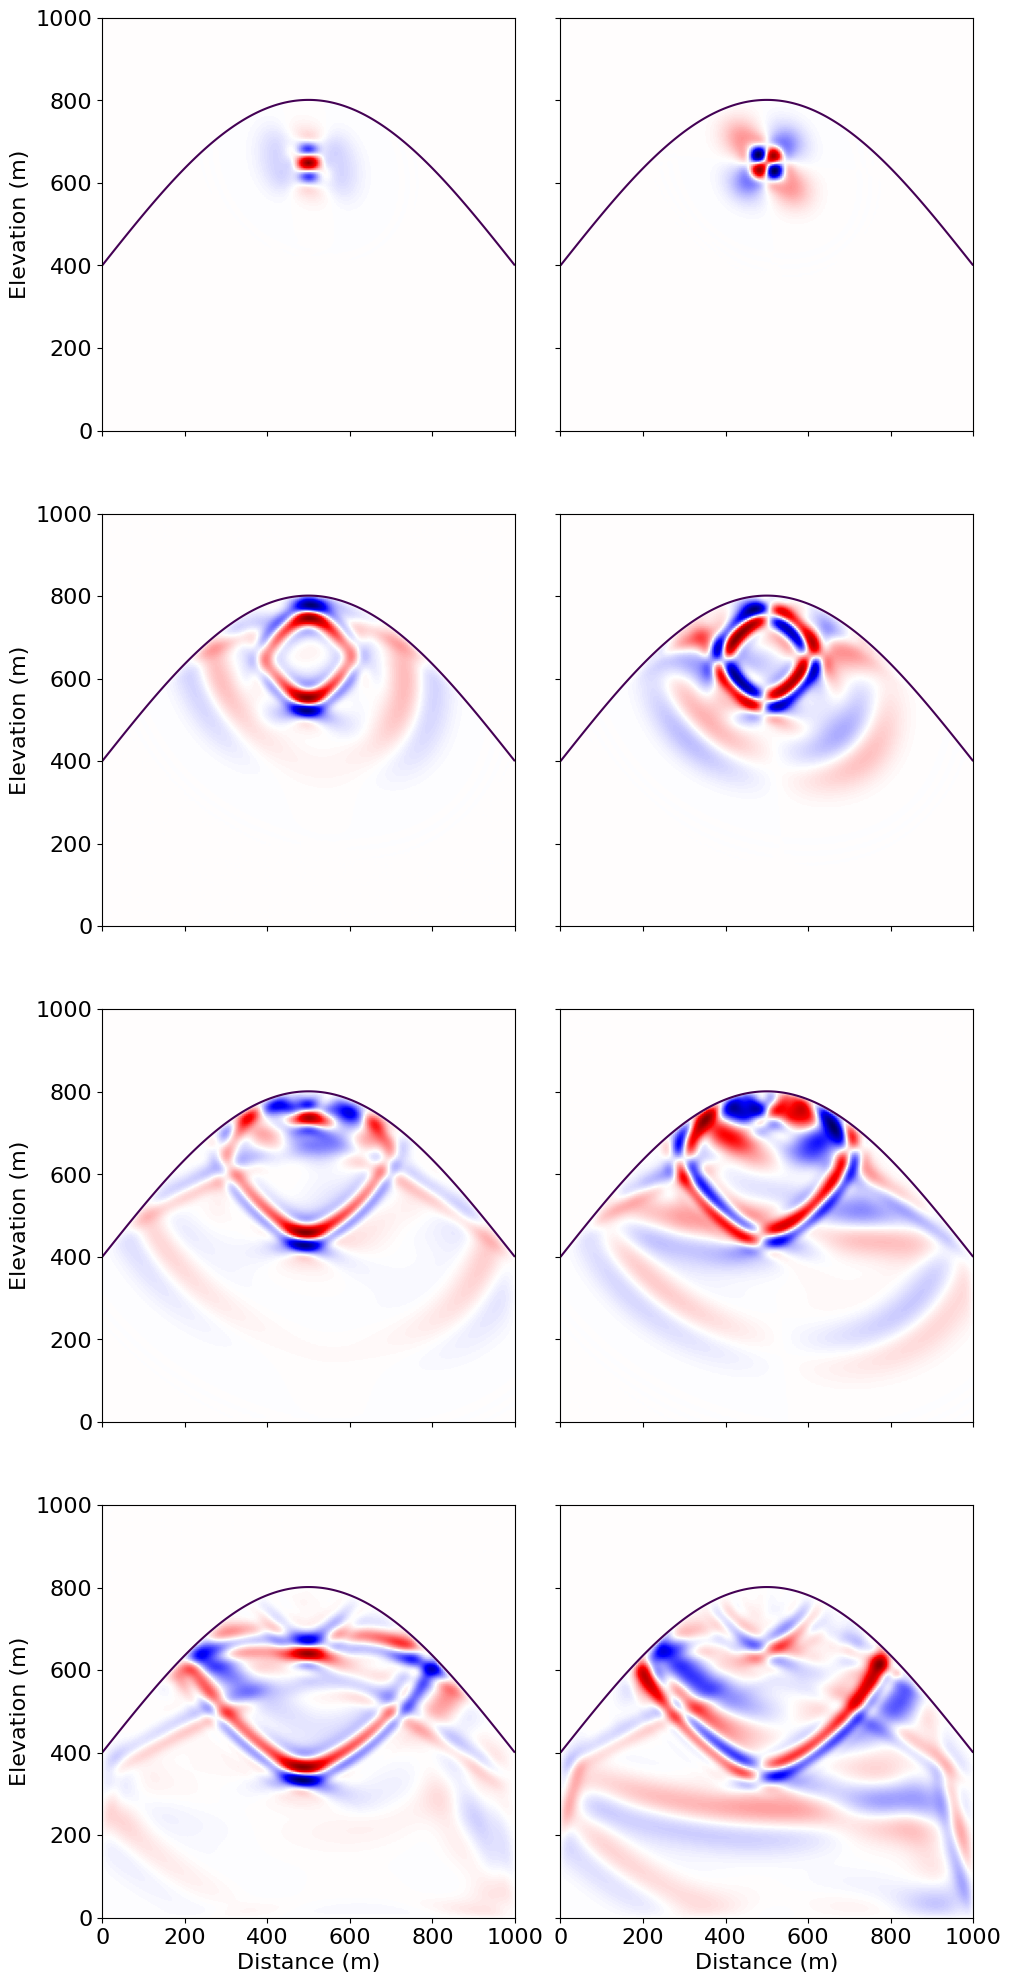

In [21]:
def plot_snaps(uxsave_data, uysave_data, sdf, file):
    for i in range(1, 5):
        print(np.linalg.norm(uxsave_data[i])
              + np.linalg.norm(uysave_data[i]))
    # Plot extent
    plt_ext = (0., 1000., 0., 1000.)

    # Plot surface with SDF contours
    xvals = np.linspace(0., 1000., uxsave_data.shape[1])
    yvals = np.linspace(0., 1000., uxsave_data.shape[2])
    xmsh, ymsh = np.meshgrid(xvals, yvals, indexing='ij')

    fig, axs = plt.subplots(4, 2, constrained_layout=True,
                            figsize=(10, 20),
                            sharex=True, sharey=True)

    for i in range(1, 5):
        vmax = np.amax(np.abs(uxsave_data[i]))
        vmin = -vmax
        axs[i-1, 0].imshow(uxsave_data[i].T, origin='lower',
                           extent=plt_ext, vmax=vmax, vmin=vmin,
                           cmap='seismic')
        axs[i-1, 0].contour(xmsh, ymsh, sdf.data, [0])
        if i == 4:
            axs[i-1, 0].set_xlabel("Distance (m)")
        axs[i-1, 0].set_ylabel("Elevation (m)")

    for i in range(1, 5):
        vmax = np.amax(np.abs(uysave_data[i]))
        vmin = -vmax
        axs[i-1, 1].imshow(uysave_data[i].T, origin='lower',
                           extent=plt_ext, vmax=vmax, vmin=vmin,
                           cmap='seismic')
        axs[i-1, 1].contour(xmsh, ymsh, sdf.data, [0])
        if i == 4:
            axs[i-1, 1].set_xlabel("Distance (m)")
    plt.savefig(file)
    plt.show()
    

plot_snaps(uxsave.data, uysave.data, sdf, 'elastic_tti_filtered')

195.30121
228.20981
12333.784
2334225700.0


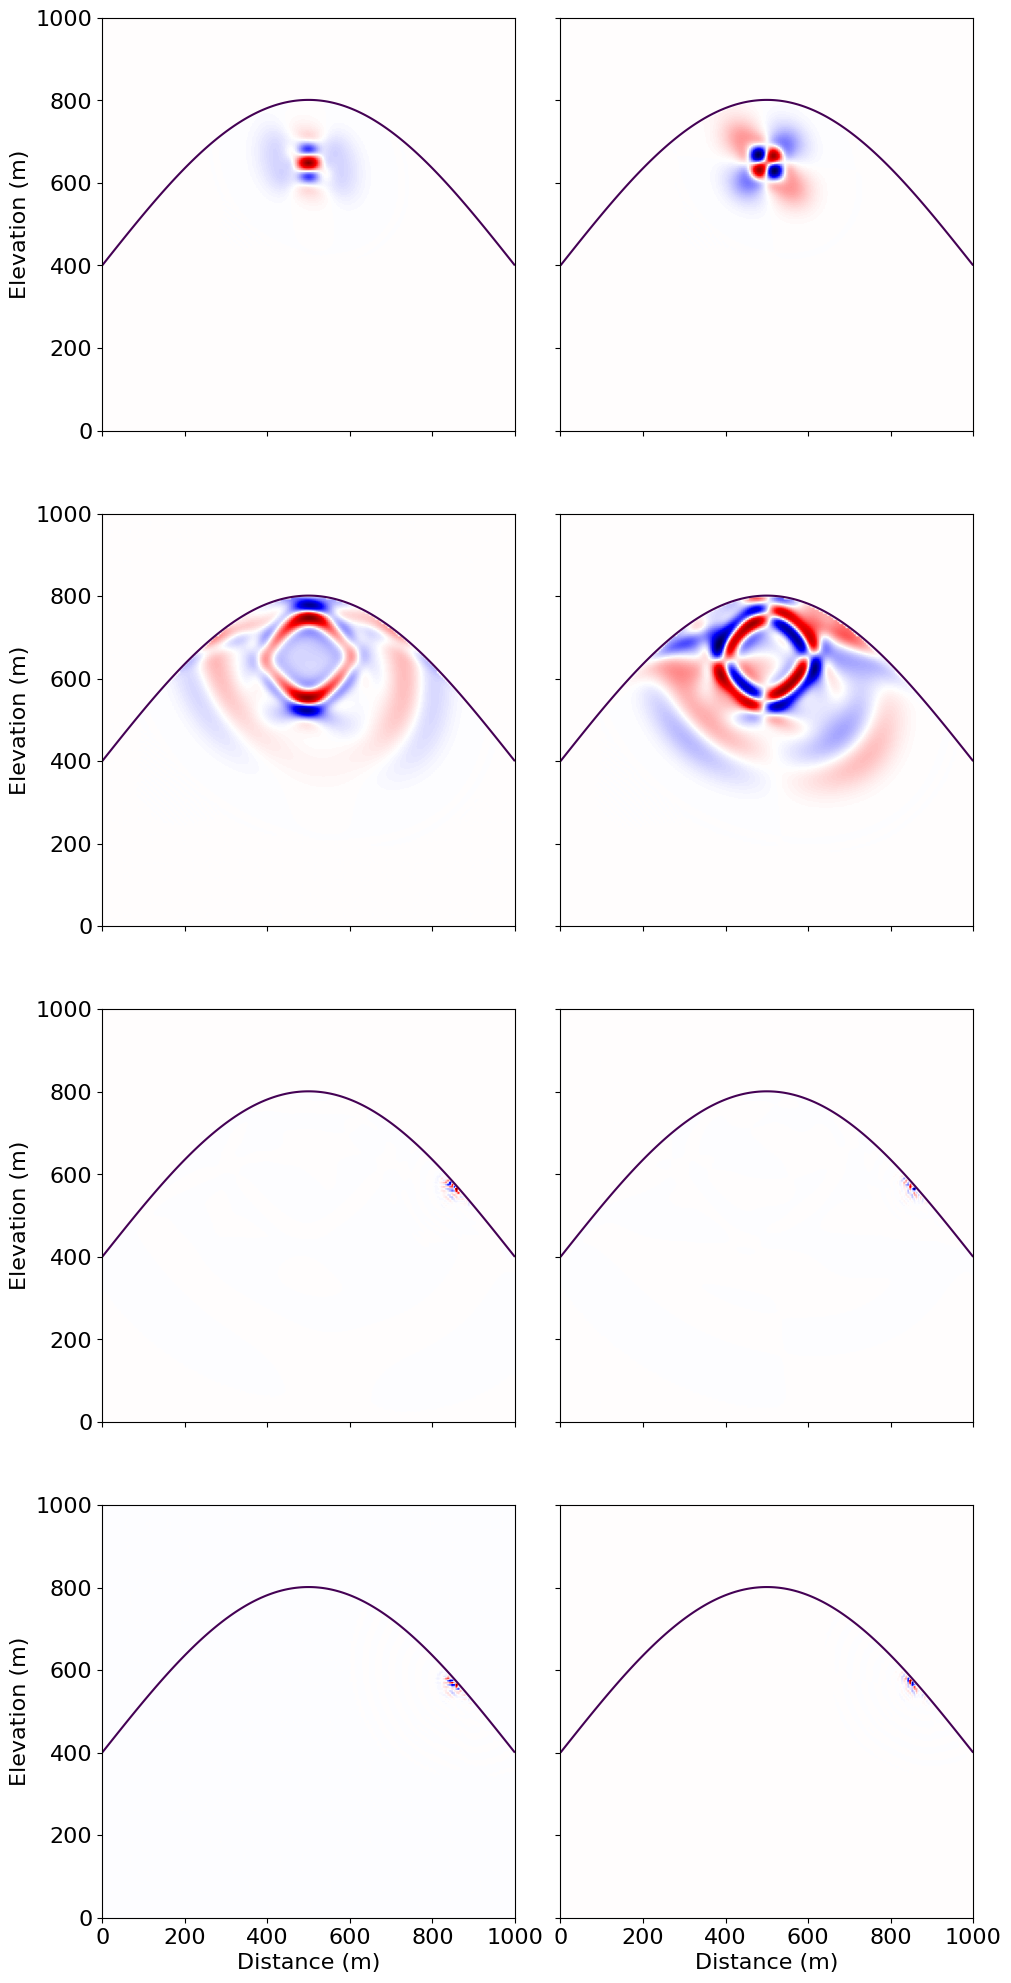

In [22]:
plot_snaps(uxsave_old, uysave_old, sdf, 'elastic_tti_unfiltered')